In [1]:
from time import time
from collections import defaultdict
from pathlib import Path
from dataclasses import dataclass
from itertools import combinations
from typing import Tuple

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame, concatenate, match_coordinates_sky, search_around_sky
from astropy.coordinates import match_coordinates_sky
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:

@dataclass
class Catalogue:
    beam: int
    table: Table
    path: Path
    center: SkyCoord
    fixed: bool = False
    offset = (0,0)
    
    def __repr__(self):
        return f"Catalogue(beam={self.beam}, table={len(self.table)} sources, path={self.path}, fixed={self.fixed})"

def estimate_skycoord_centre(
    sky_positions: SkyCoord, final_frame: str = "fk5"
) -> SkyCoord:
    
    xyz_positions = sky_positions.cartesian.xyz
    xyz_mean_position = np.mean(xyz_positions, axis=1)

    mean_position = SkyCoord(
        *xyz_mean_position, representation_type="cartesian"
    ).transform_to(final_frame)

    return mean_position

def filter_table(table: Table):
    sky_coord = SkyCoord(table["ra"], table["dec"], unit=(u.deg, u.deg))
    
    isolation_mask = sky_coord.match_to_catalog_sky(sky_coord, nthneighbor=2)[1] > (0.01 * u.deg)
    
    ratio = table["int_flux"] / table["peak_flux"]
    ratio_mask = (0.8 < ratio) & (ratio < 1.2)

    return isolation_mask & ratio_mask
                         
def get_catalogues(apply_filter_table=True):
    catalogues = []
    for beam in range(36):
        path = Path(f"catalogues/SB57171.RACS_1110-51.beam{beam:02d}.i.MFS.image_comp.fits")
        table = Table.read(path)
        
        table_mask = filter_table(table=table)
        sub_table = table[table_mask]

        center = estimate_skycoord_centre(
            SkyCoord(table["ra"], table["dec"], unit=(u.deg, u.deg))
        )
        
        catalogues.append(
            Catalogue(beam=beam, table=sub_table, path=path, center=center)
        )
    return catalogues

catas = get_catalogues()
catas

[Catalogue(beam=0, table=268 sources, path=catalogues/SB57171.RACS_1110-51.beam00.i.MFS.image_comp.fits, fixed=False),
 Catalogue(beam=1, table=262 sources, path=catalogues/SB57171.RACS_1110-51.beam01.i.MFS.image_comp.fits, fixed=False),
 Catalogue(beam=2, table=287 sources, path=catalogues/SB57171.RACS_1110-51.beam02.i.MFS.image_comp.fits, fixed=False),
 Catalogue(beam=3, table=291 sources, path=catalogues/SB57171.RACS_1110-51.beam03.i.MFS.image_comp.fits, fixed=False),
 Catalogue(beam=4, table=268 sources, path=catalogues/SB57171.RACS_1110-51.beam04.i.MFS.image_comp.fits, fixed=False),
 Catalogue(beam=5, table=259 sources, path=catalogues/SB57171.RACS_1110-51.beam05.i.MFS.image_comp.fits, fixed=False),
 Catalogue(beam=6, table=262 sources, path=catalogues/SB57171.RACS_1110-51.beam06.i.MFS.image_comp.fits, fixed=False),
 Catalogue(beam=7, table=273 sources, path=catalogues/SB57171.RACS_1110-51.beam07.i.MFS.image_comp.fits, fixed=False),
 Catalogue(beam=8, table=285 sources, path=catal

In [3]:
def make_sky_coords(table):
    if isinstance(table, Catalogue):
        table = table.table
    sky_pos = SkyCoord(table["ra"], table["dec"], unit=(u.deg, u.deg))
    return sky_pos

def create_catalogue_matrix(catas):
    no_catas = len(catas)
    match_matrix = np.zeros((no_catas, no_catas))

    combos = list(combinations(list(range(36)), 2))

    for (b1, b2) in combos:
        cata_1, cata_2 = catas[b1], catas[b2]
        
        sky_pos_1, sky_pos_2 = make_sky_coords(cata_1), make_sky_coords(cata_2)
        
        match_results = search_around_sky(
            sky_pos_1, sky_pos_2, seplimit=9*u.arcsec
        )
        match_matrix[b1,b2] = len(match_results[0])

    return match_matrix

def plot_matrix(matrix):
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    cim = ax1.imshow(matrix)
    fig.colorbar(cim, label="N")
    ax1.set(
        xlabel="Beam no.",
        ylabel="Beam no.",
        title="Source matches"
    )
    
    ax2.hist(matrix[matrix > 0].flatten(), bins=20)
    ax2.set(
        xlabel="Number of matches",
        ylabel="Count"
    )



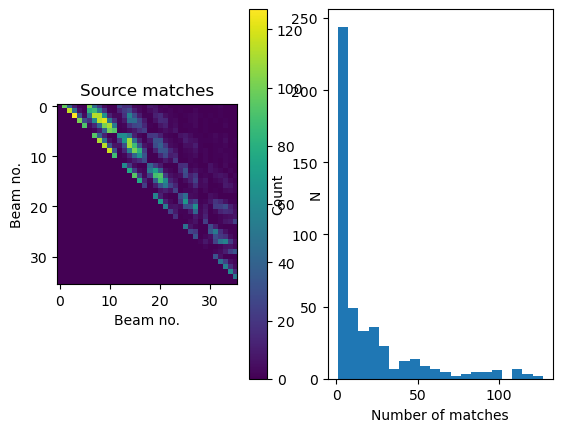

In [4]:
matrix = create_catalogue_matrix(catas=catas)
plot_matrix(matrix=matrix)


[127. 122. 117. ...   0.   0.   0.]


/var/folders/3b/kbsb64bs78d1qzgmpfkgwq4800_fyl/T/ipykernel_9217/91789024.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1,2)
/Users/gal16b/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gal16b/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gal16b/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/gal16b/miniforge

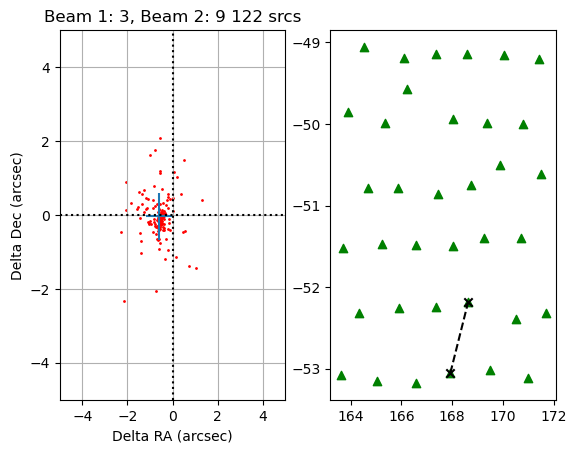

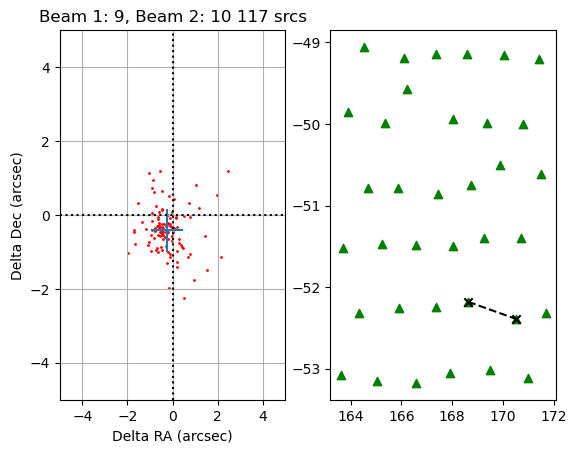

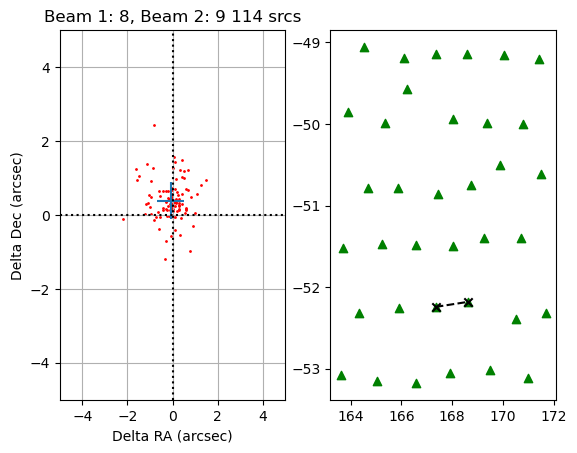

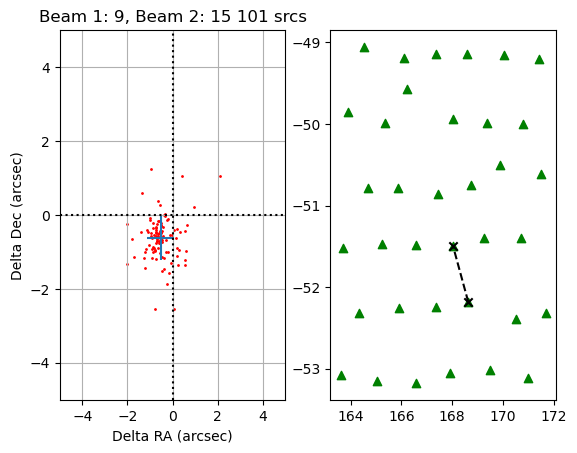

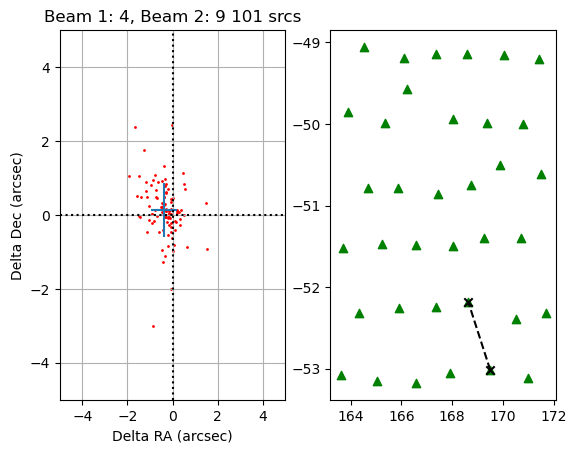

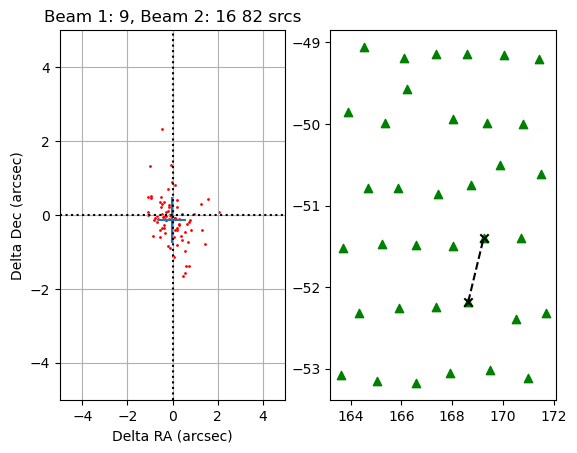

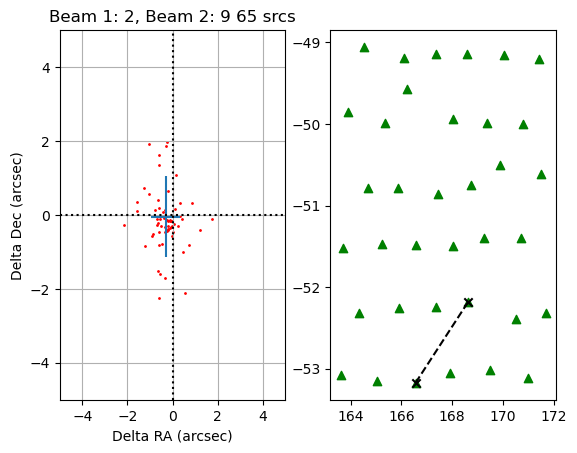

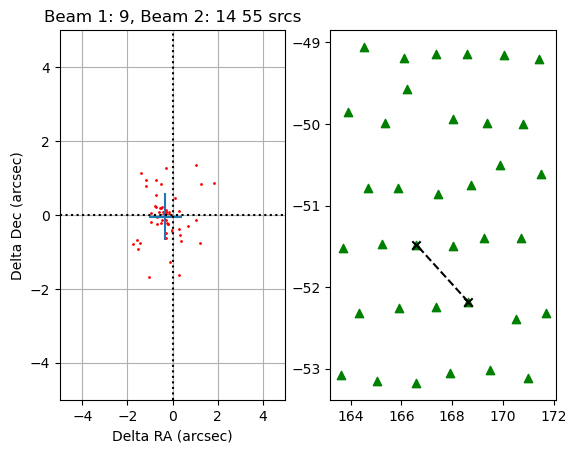

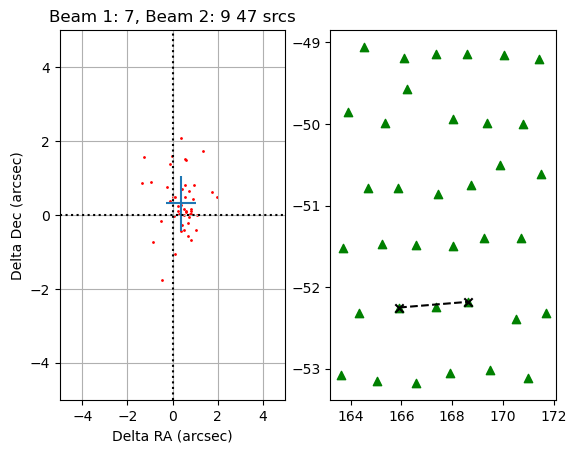

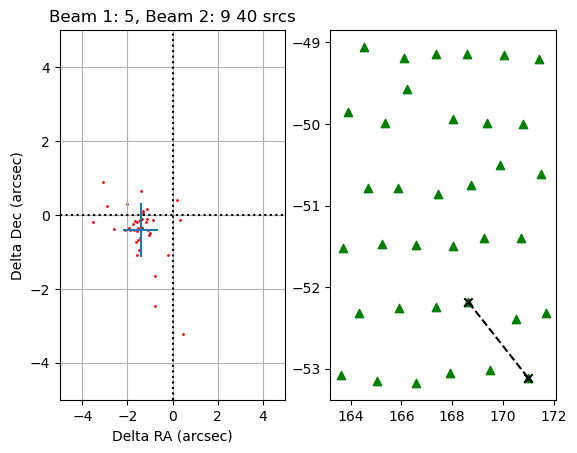

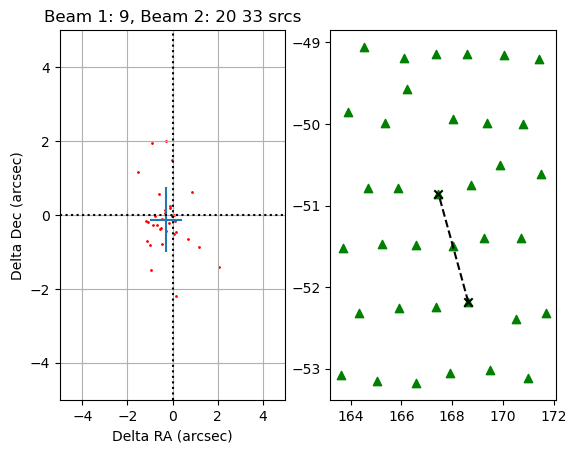

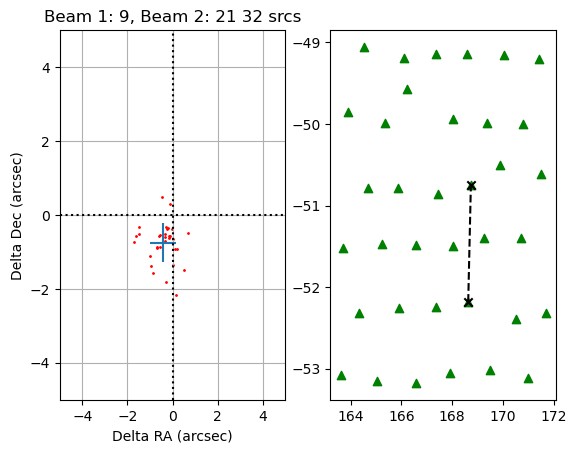

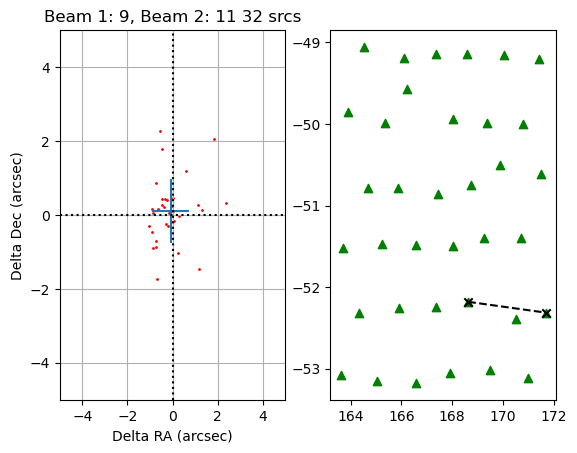

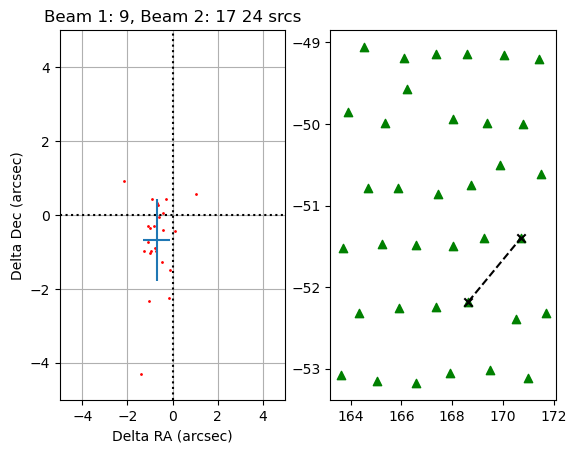

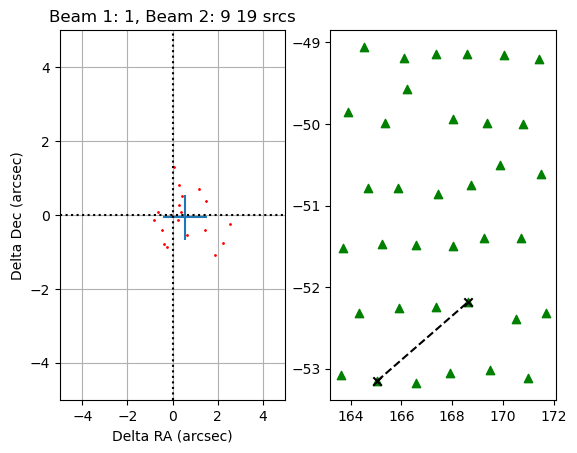

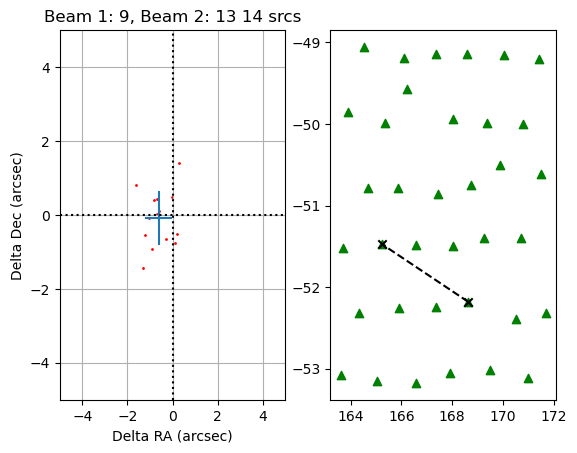

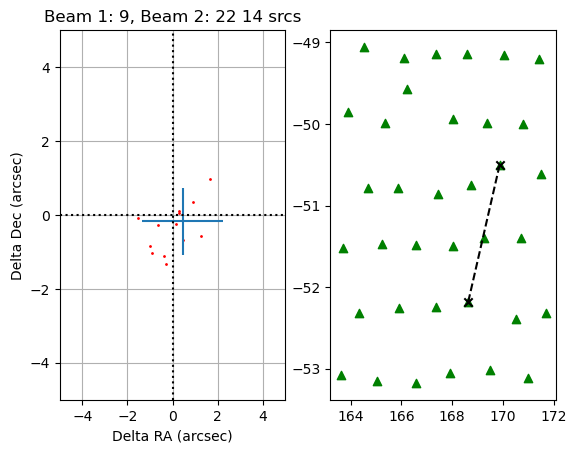

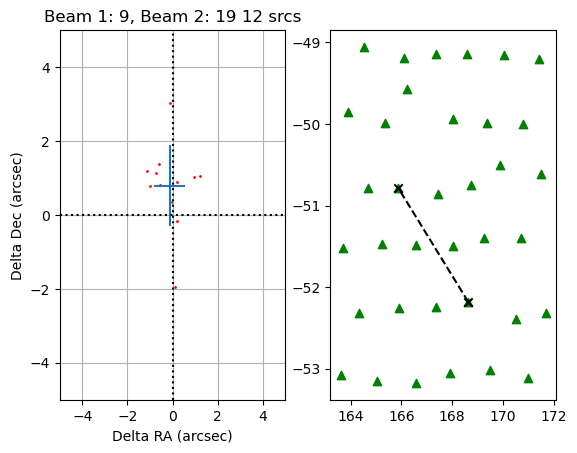

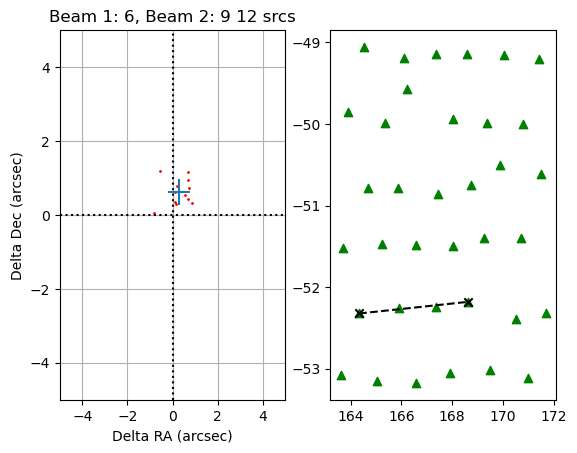

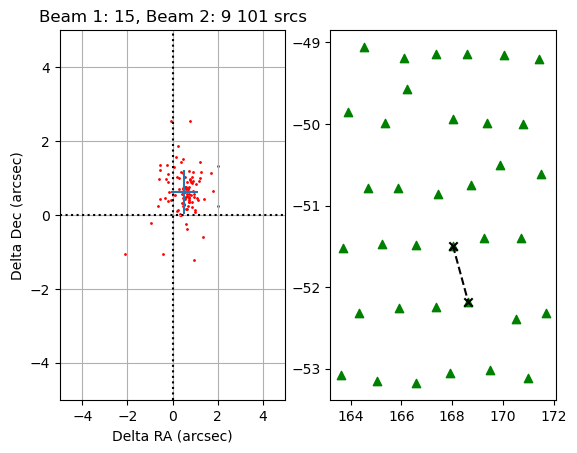

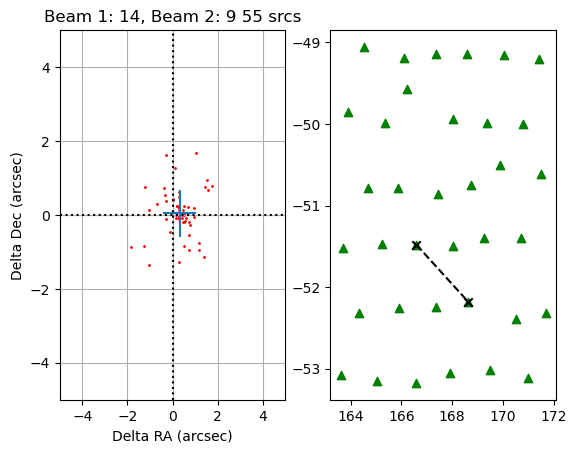

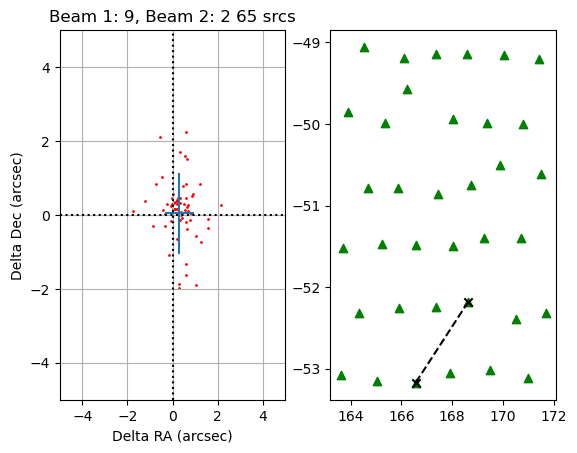

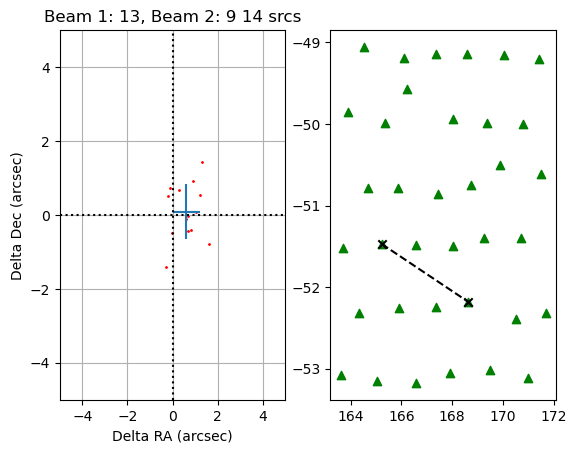

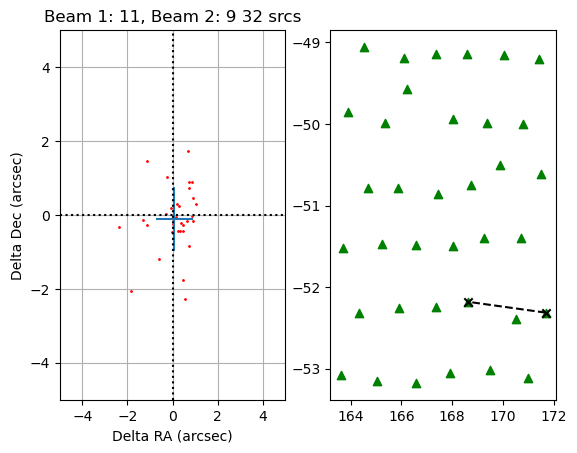

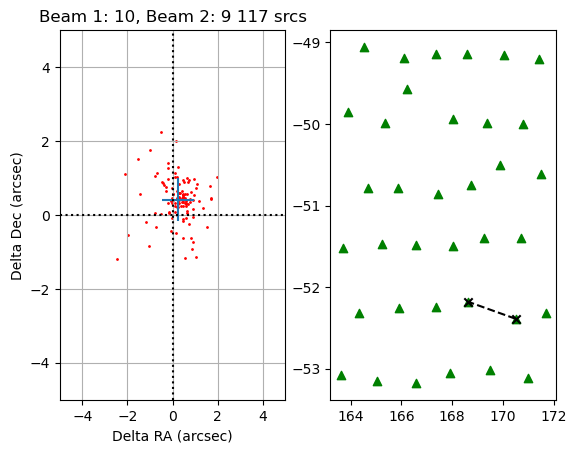

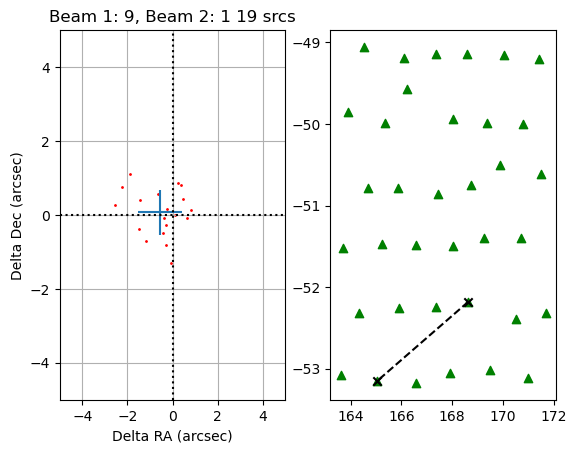

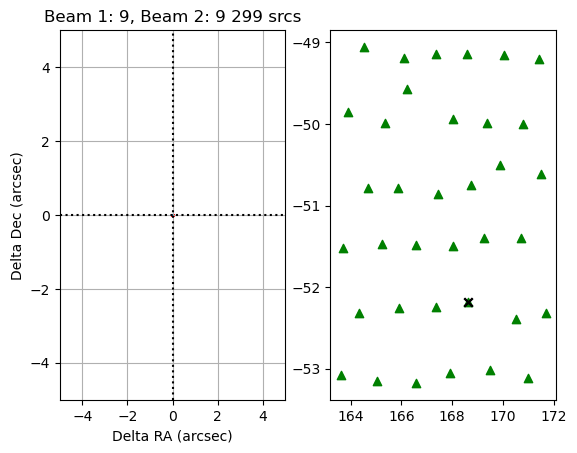

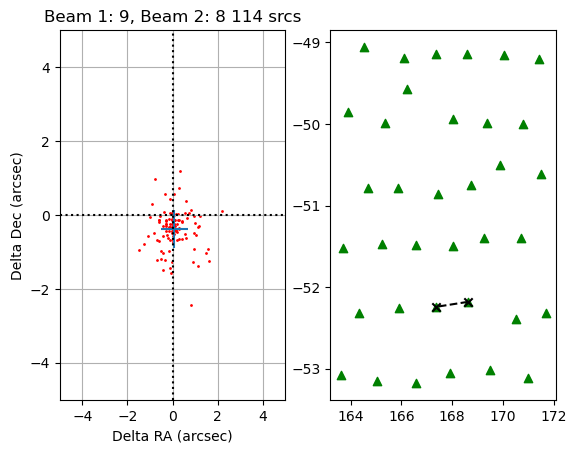

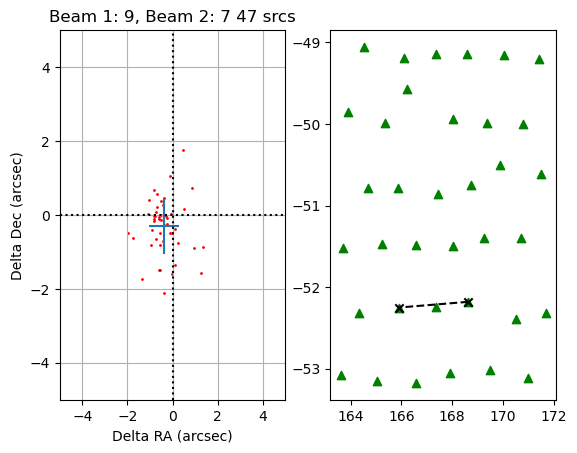

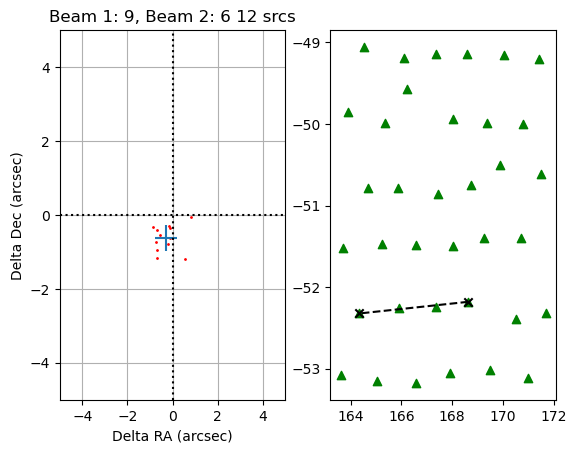

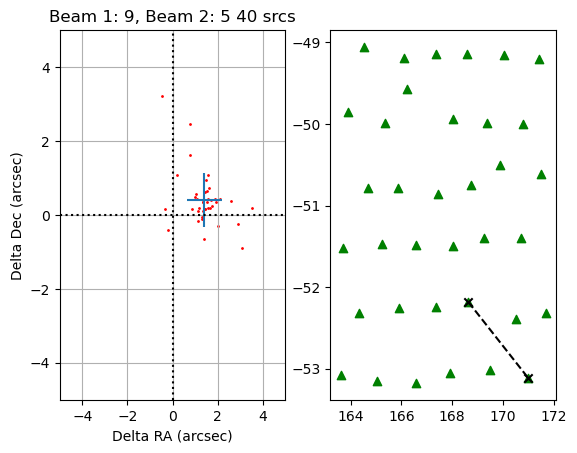

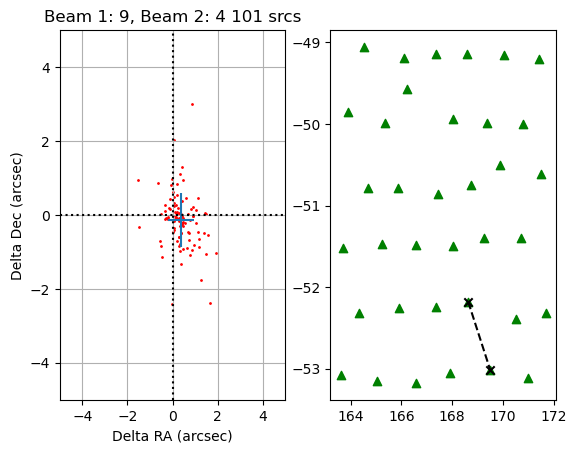

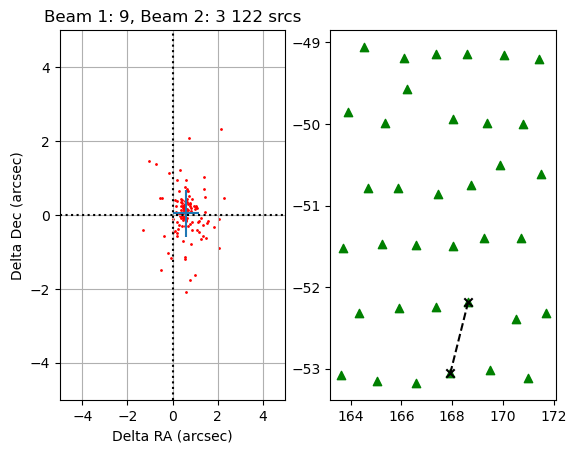

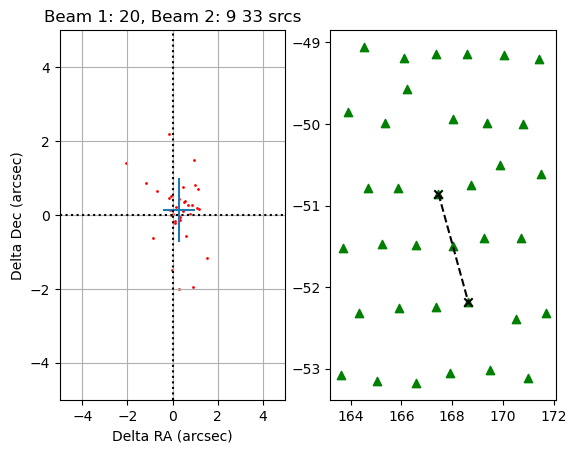

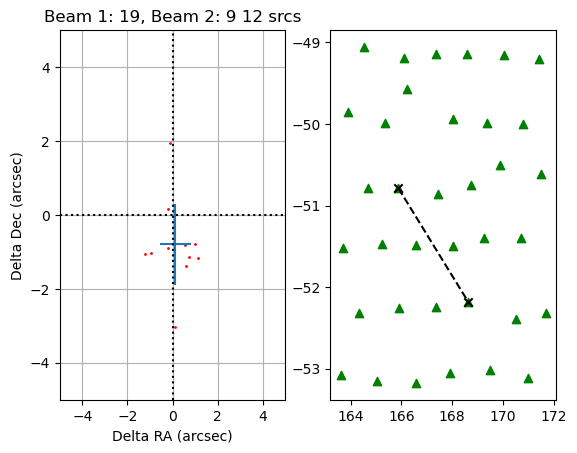

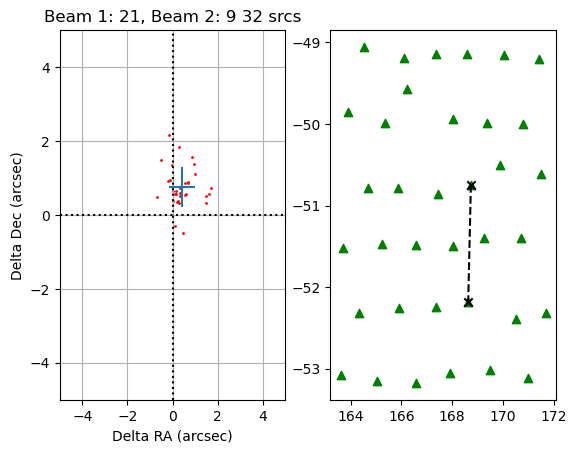

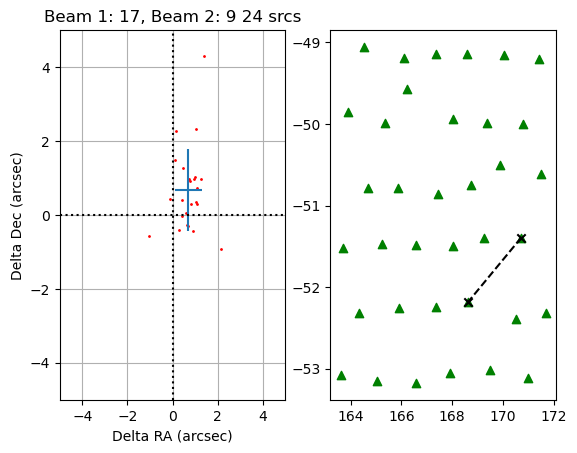

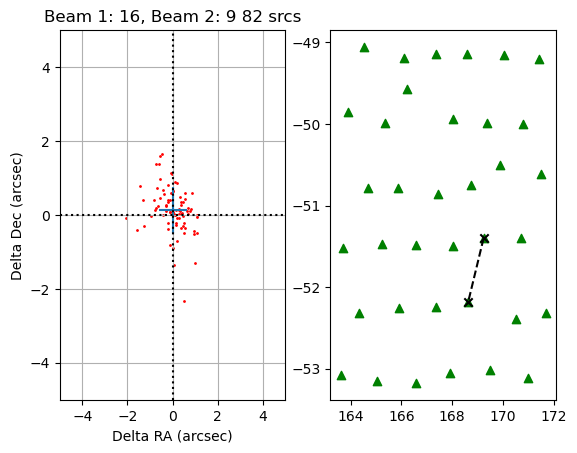

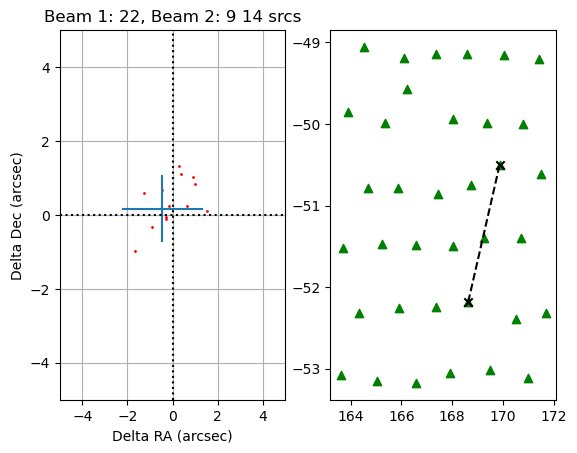

In [5]:
@dataclass
class Match:
    sky_pos_1: SkyCoord
    sky_pos_2: SkyCoord
    matches: tuple
    match_1: SkyCoord
    match_2: SkyCoord
    n: int
    offset_mean: Tuple[float,float]
    offset_std: Tuple[float,float]
    err_ra: np.ndarray
    err_dec: np.ndarray

def calculate_matches(cata1, cata2):

    sky_pos_1 = make_sky_coords(cata1)
    sky_pos_2 = make_sky_coords(cata2)

    matches = search_around_sky(
        sky_pos_1, sky_pos_2, seplimit=9*u.arcsec
    )
    match_1 = sky_pos_1[matches[0]]
    match_2 = sky_pos_2[matches[1]]

    # frame = match_1.skyoffset_frame()
    # deltas = match_2.transform_to(frame)
    deltas = match_1.spherical_offsets_to(match_2)
    
    # Get the separations between two points, and their angle between them
    # err_ra = deltas.lon.to(u.arcsec).value
    # err_dec = deltas.lat.to(u.arcsec).value
    err_ra = deltas[0].to(u.arcsec).value
    err_dec = deltas[1].to(u.arcsec).value
    
    mean_ra, mean_dec = np.mean(err_ra), np.mean(err_dec)
    std_ra, std_dec = np.std(err_ra), np.std(err_dec)
    
    return Match(
        sky_pos_1=sky_pos_1, 
        sky_pos_2=sky_pos_2, 
        matches=matches, 
        match_1=match_1, 
        match_2=match_2, 
        n=len(match_2), 
        offset_mean = (mean_ra, mean_dec),
        offset_std=(std_ra, std_dec),
        err_ra=err_ra,
        err_dec=err_dec
    )
    

def plot_astrometric_offsets(cata1, cata2, beams, ax=None):

    src_matches = calculate_matches(cata1, cata2)
    mean_ra, mean_dec = src_matches.offset_mean
    std_ra, std_dec = src_matches.offset_std
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3,3))

    ax.scatter(
        src_matches.err_ra, 
        src_matches.err_dec,
        color="red",
        s=1
    )
    ax.errorbar(
        mean_ra, mean_dec, xerr=std_ra, yerr=std_dec
    )
    ax.set(
        xlabel="Delta RA (arcsec)",
        ylabel="Delta Dec (arcsec)",
        title=f"Beam 1: {beams[0]}, Beam 2: {beams[1]} {len(src_matches.err_ra)} srcs",
        xlim=[-5,5], ylim=[-5,5]
    )
    ax.grid()
    ax.axvline(0, color="black", ls=":")
    ax.axhline(0, color="black", ls=":")


def plot_beam_locations(catas, beam1, beam2, ax=None):
    ras = np.array([c.center.ra.deg for c in catas])
    decs = np.array([c.center.dec.deg for c in catas])
    fixed = np.array([c.fixed for c in catas])
    
    beam1_pos = beam1.center
    beam2_pos = beam2.center

    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.scatter(ras[fixed], decs[fixed], color="red", marker="o")
    ax.scatter(ras[~fixed], decs[~fixed], color="green", marker="^")
    
    ax.scatter(beam1_pos.ra.deg, beam1_pos.dec.deg, color="black", marker="x")
    ax.scatter(beam2_pos.ra.deg, beam2_pos.dec.deg, color="black", marker="x")
    ax.plot(
        (beam1_pos.ra.deg, beam2_pos.ra.deg),
        (beam1_pos.dec.deg, beam2_pos.dec.deg),
        ls="--",
        c="black"
    )

plt.close("all")

order = np.argsort(matrix.flatten())[::-1]
order
print(matrix.flatten()[order])
unravel_order = np.unravel_index(order, matrix.shape)

centers = [cata.center for cata in catas]

for beams in zip(*unravel_order):
    if 9 not in beams:
        continue
    matches = calculate_matches(catas[beams[0]], catas[beams[1]])
    if matches.n < 10:
        continue
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    plot_astrometric_offsets(catas[beams[0]], catas[beams[1]], beams, ax=ax1)
    plot_beam_locations(catas, catas[beams[0]], catas[beams[1]], ax=ax2)


In [6]:

def set_seed_cata(catas):
    sum_matrix = np.sum(matrix, axis=0
                       )
    idx = np.argmax(sum_matrix)
    catas[idx].fixed = True

    assert len([cata.fixed for cata in catas if cata.fixed]) == 1, "Too many seeds"
    
    return catas


In [7]:
catas = set_seed_cata(catas)

Round 0, StepInfo(accumulated_seps=<Angle 2.98317003 deg>, number_of_matches=9184)
Round 1, StepInfo(accumulated_seps=<Angle 2.96273676 deg>, number_of_matches=9184)
Round 2, StepInfo(accumulated_seps=<Angle 2.9068887 deg>, number_of_matches=9184)
Round 3, StepInfo(accumulated_seps=<Angle 2.90086912 deg>, number_of_matches=9184)
Round 4, StepInfo(accumulated_seps=<Angle 2.89241913 deg>, number_of_matches=9184)
Round 5, StepInfo(accumulated_seps=<Angle 2.88291925 deg>, number_of_matches=9184)
Round 6, StepInfo(accumulated_seps=<Angle 2.84269148 deg>, number_of_matches=9184)
Round 7, StepInfo(accumulated_seps=<Angle 2.81512832 deg>, number_of_matches=9184)
Round 8, StepInfo(accumulated_seps=<Angle 2.77188488 deg>, number_of_matches=9184)
Round 9, StepInfo(accumulated_seps=<Angle 2.62664635 deg>, number_of_matches=9184)
Round 10, StepInfo(accumulated_seps=<Angle 2.61671341 deg>, number_of_matches=9184)
Round 11, StepInfo(accumulated_seps=<Angle 2.61669224 deg>, number_of_matches=9184)
Rou

/var/folders/3b/kbsb64bs78d1qzgmpfkgwq4800_fyl/T/ipykernel_9217/3412332538.py:135: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))


Round 20, StepInfo(accumulated_seps=<Angle 2.47814802 deg>, number_of_matches=9184)
Round 21, StepInfo(accumulated_seps=<Angle 2.45244908 deg>, number_of_matches=9184)
Round 22, StepInfo(accumulated_seps=<Angle 2.42528818 deg>, number_of_matches=9184)
Round 23, StepInfo(accumulated_seps=<Angle 2.42523289 deg>, number_of_matches=9184)
Round 24, StepInfo(accumulated_seps=<Angle 2.37104197 deg>, number_of_matches=9184)
Round 25, StepInfo(accumulated_seps=<Angle 2.32071183 deg>, number_of_matches=9184)
Round 26, StepInfo(accumulated_seps=<Angle 2.31361642 deg>, number_of_matches=9184)
Round 27, StepInfo(accumulated_seps=<Angle 2.29789311 deg>, number_of_matches=9184)
Round 28, StepInfo(accumulated_seps=<Angle 2.27536702 deg>, number_of_matches=9184)
Round 29, StepInfo(accumulated_seps=<Angle 2.26228202 deg>, number_of_matches=9184)
Round 30, StepInfo(accumulated_seps=<Angle 2.20828004 deg>, number_of_matches=9183)
Round 31, StepInfo(accumulated_seps=<Angle 2.19946869 deg>, number_of_matche

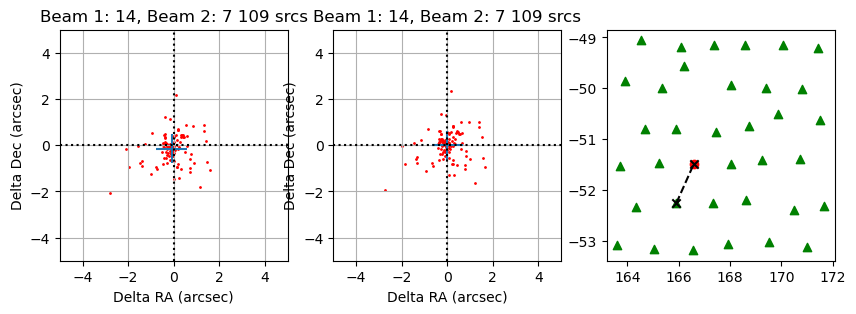

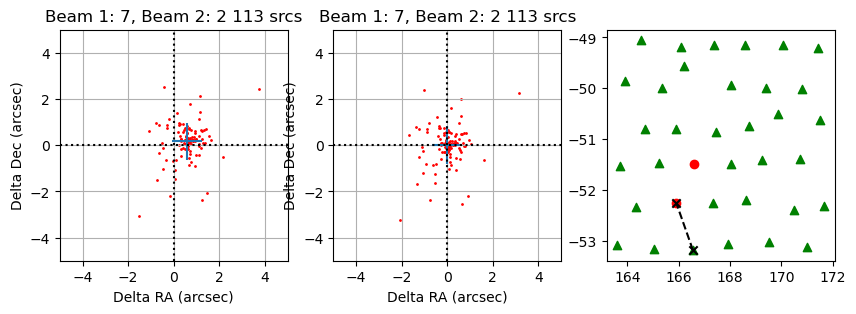

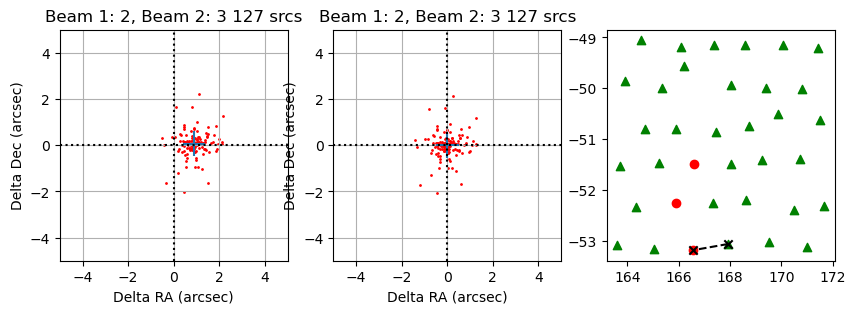

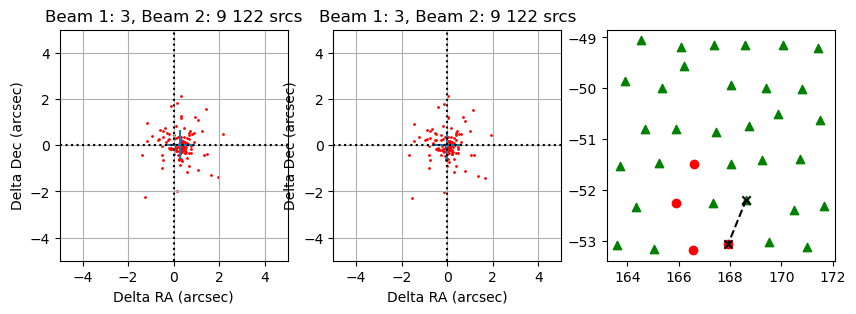

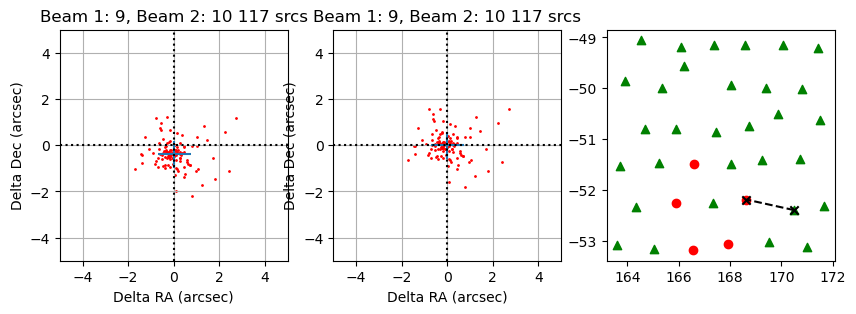

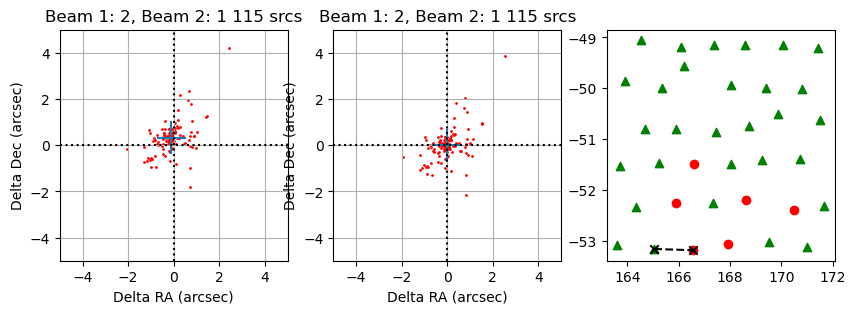

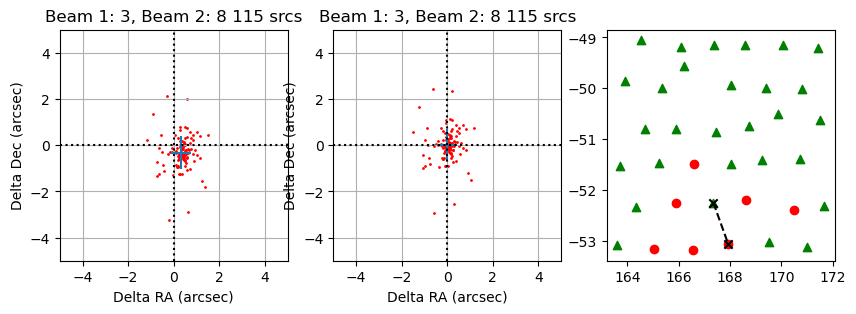

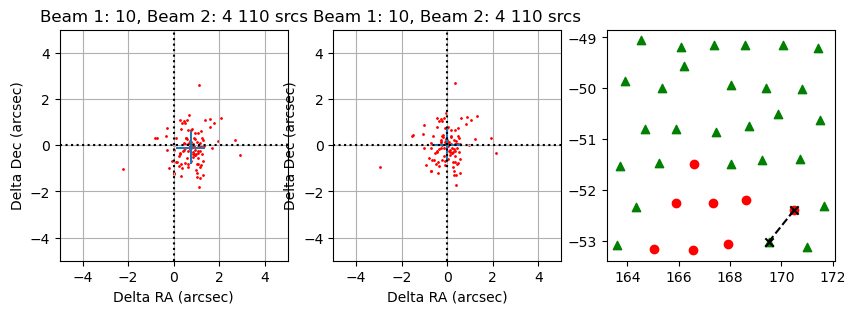

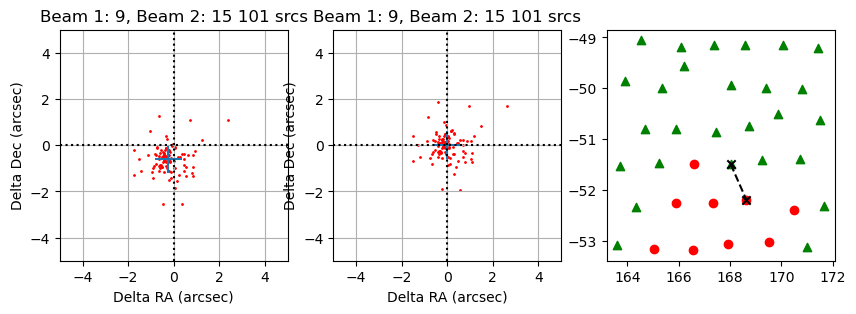

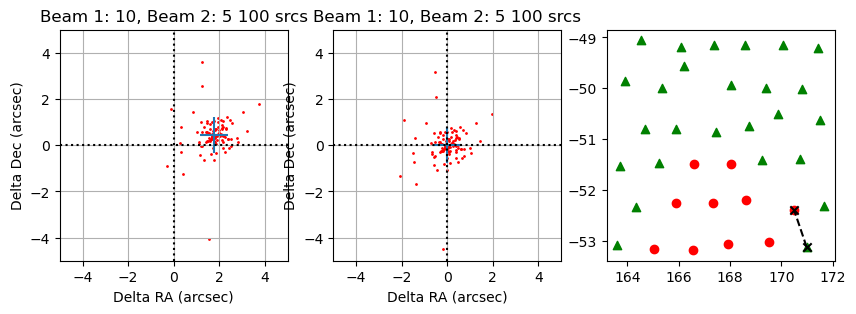

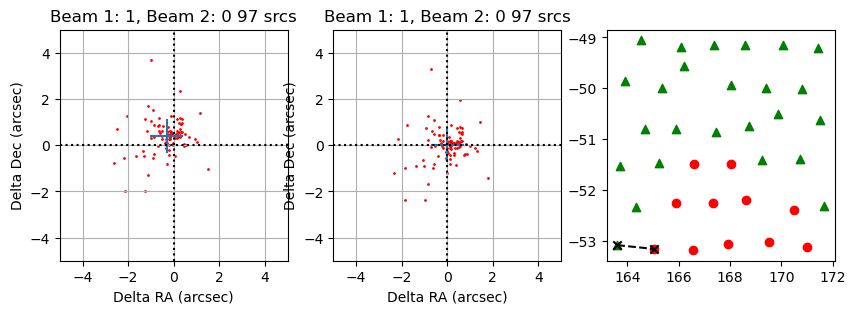

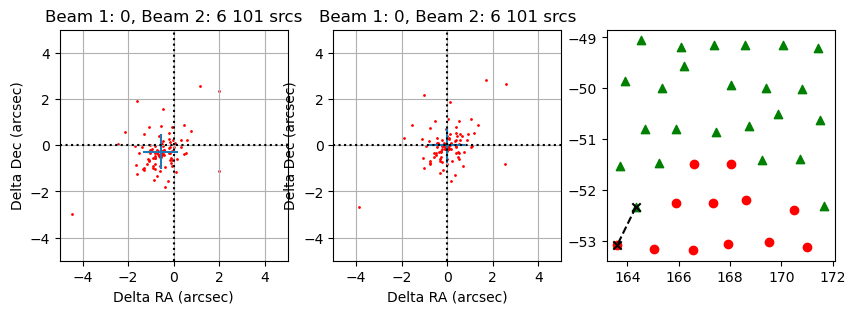

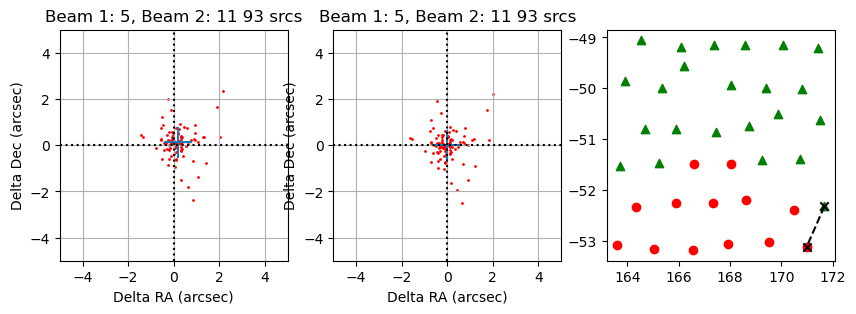

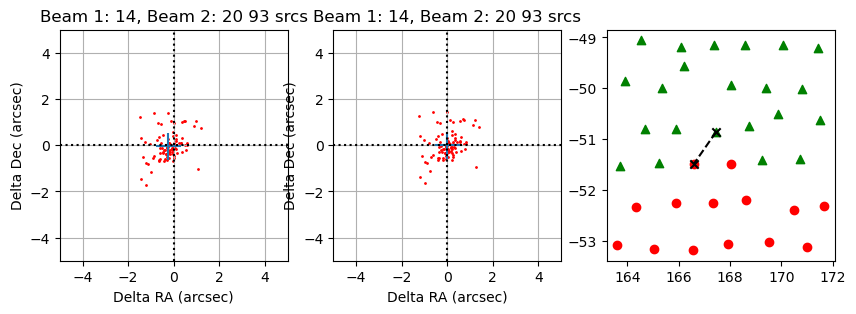

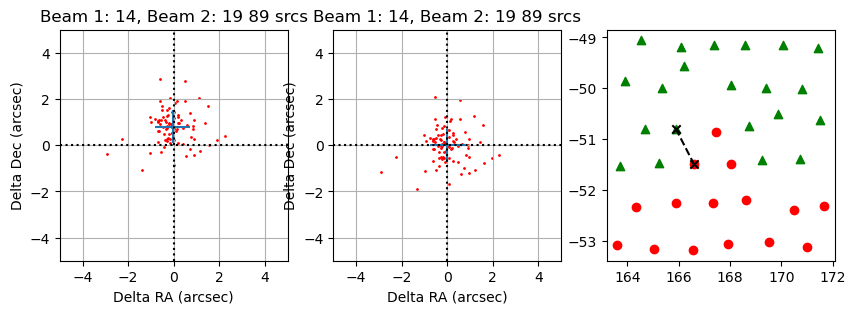

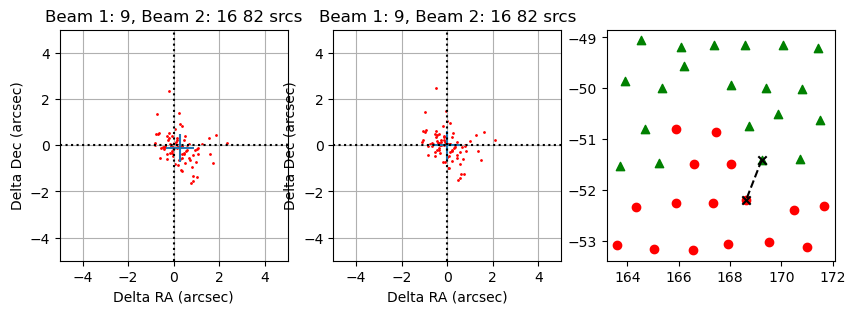

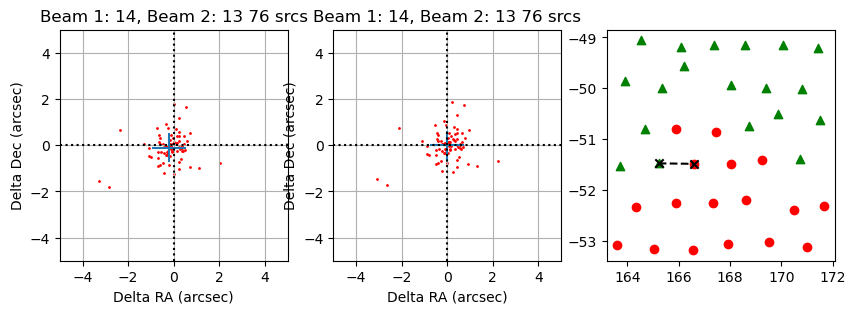

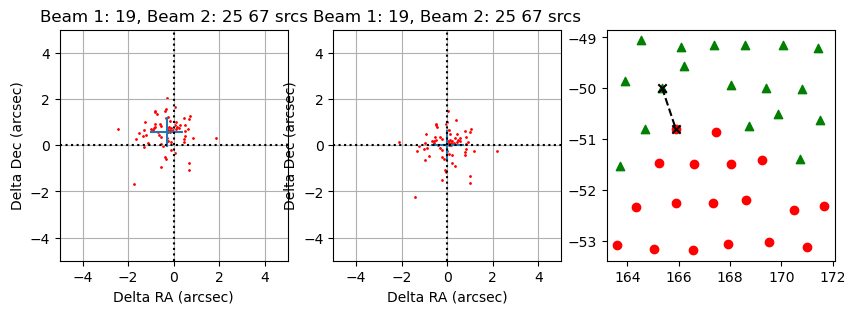

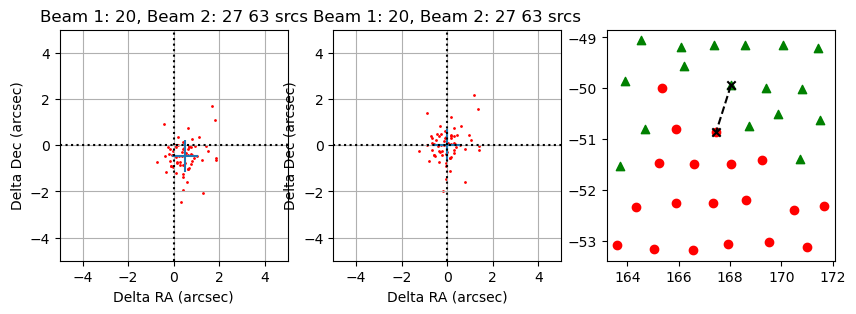

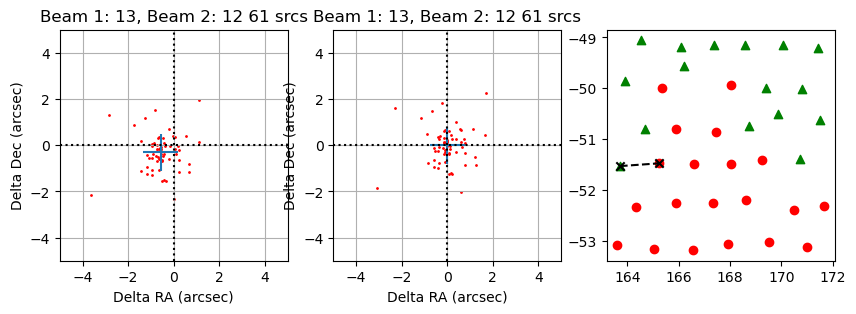

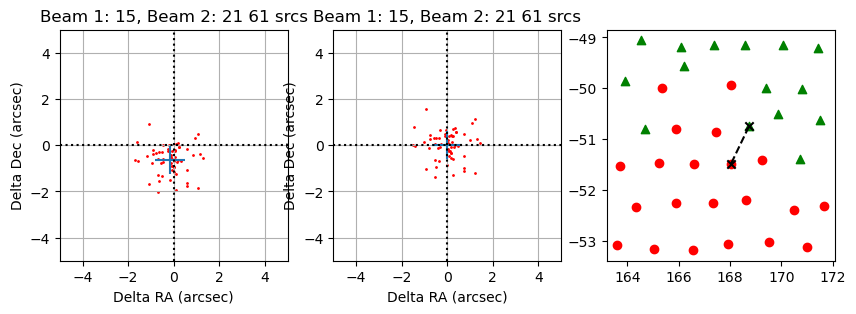

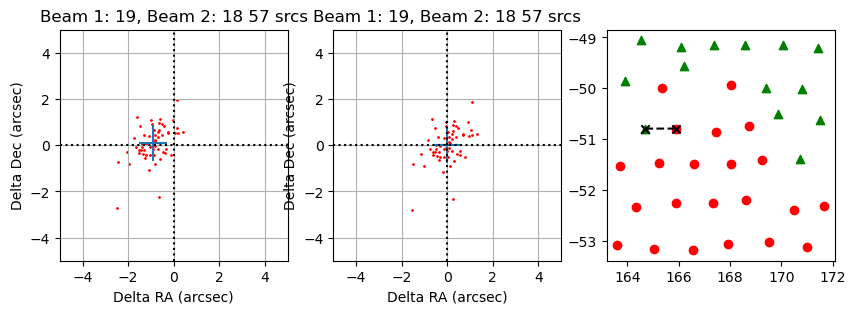

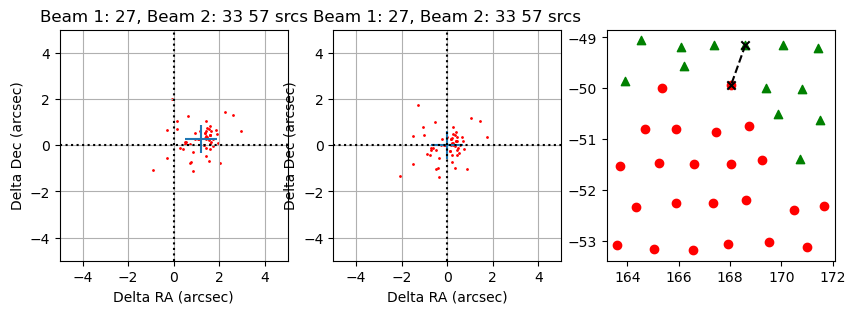

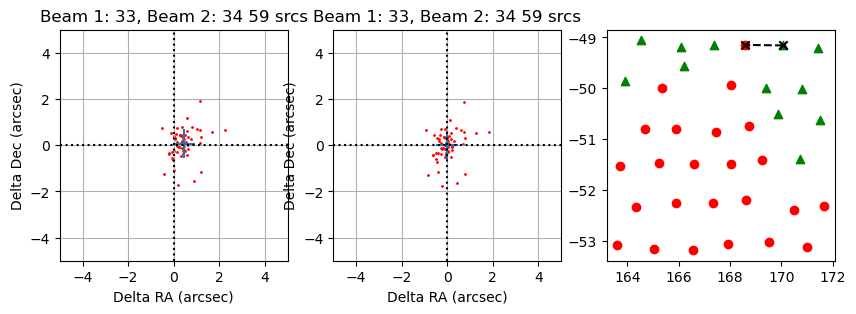

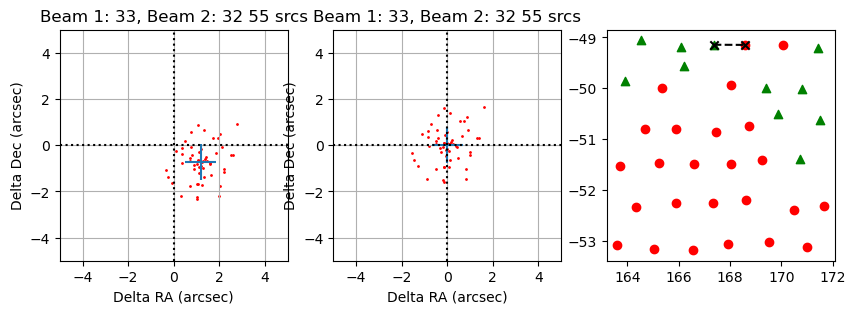

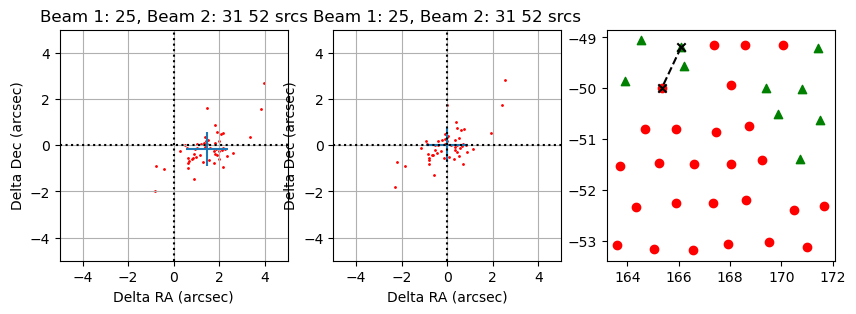

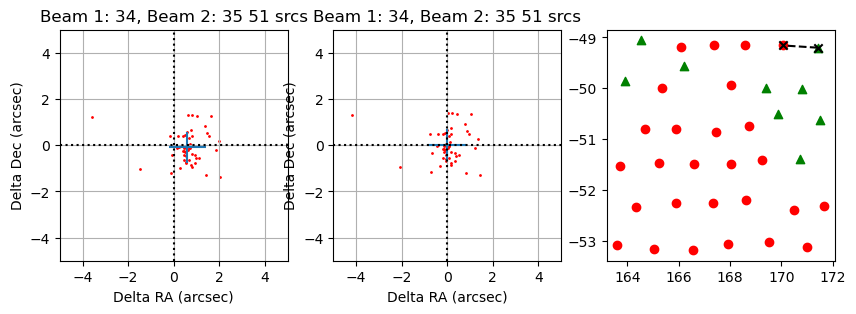

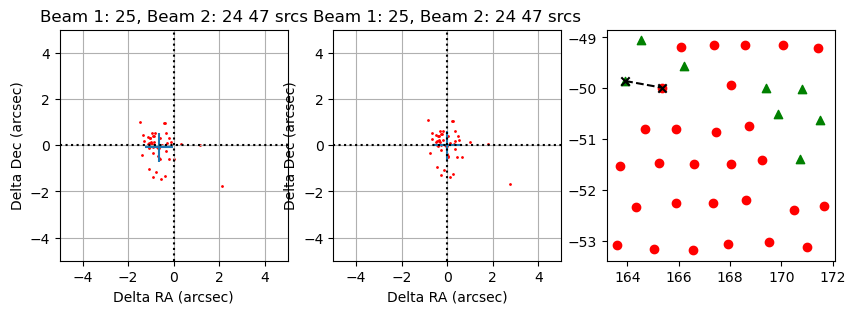

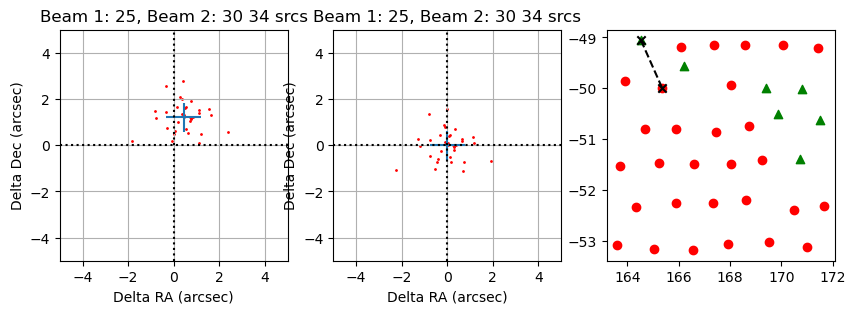

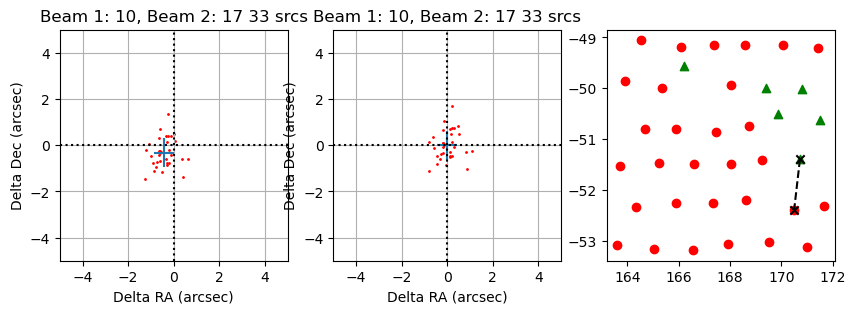

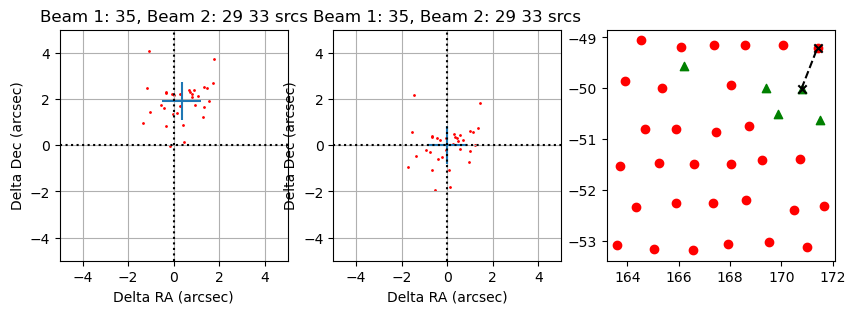

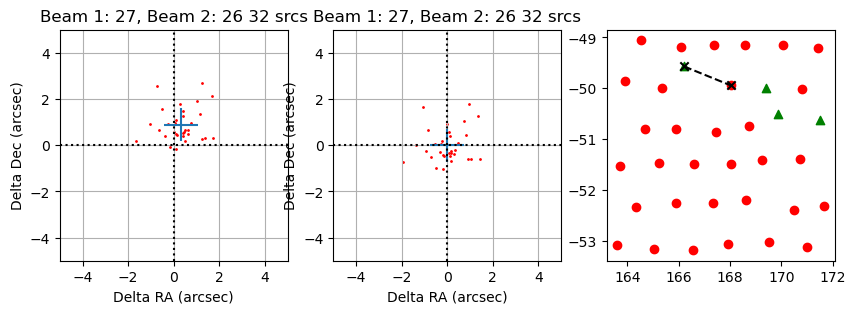

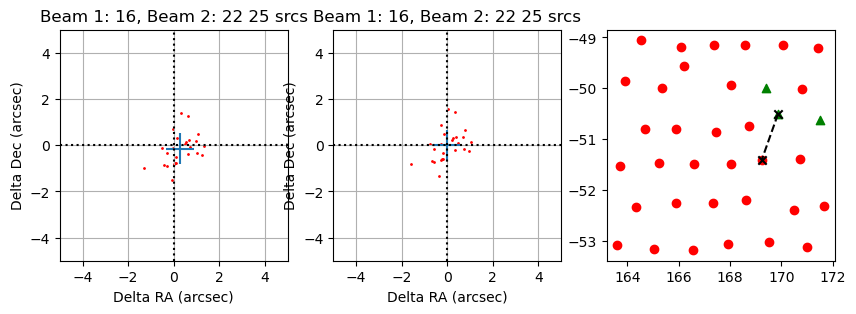

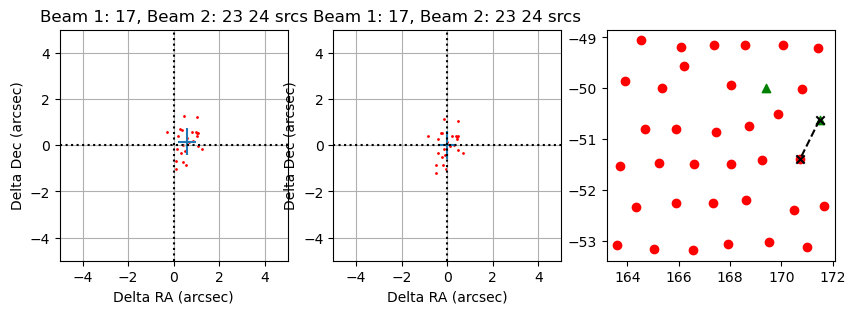

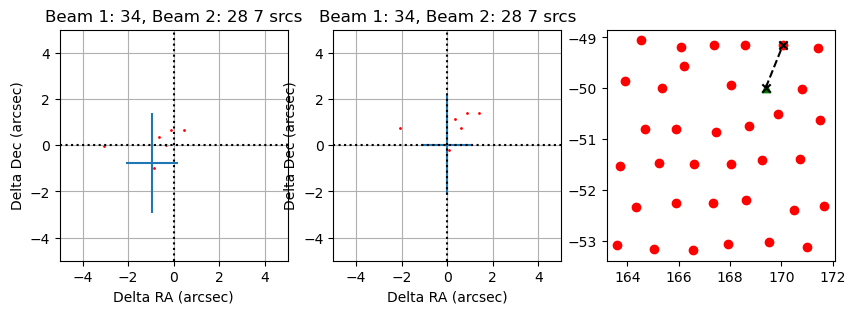

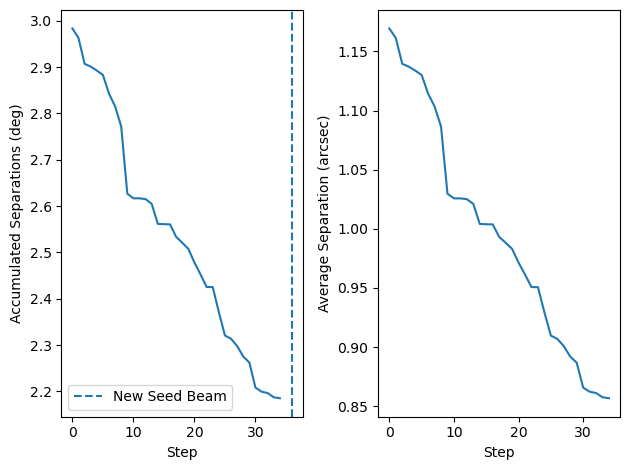

In [8]:

@dataclass
class BeamPair:
    fixed_beam_idx: int
    shift_beam_idx: int
    matches: Match

def find_next_pair(catas):

    assert any([cata.fixed for cata in catas]), "There are no fixed catalogues"

    fixed_beam_idxs = [idx for idx, cata in enumerate(catas) if cata.fixed]
    candidate_beam_idxs =  [idx for idx, cata in enumerate(catas) if not cata.fixed] 

    # print(f"{fixed_beam_idxs=}")
    # print(f"{candidate_beam_idxs=}")
    
    if len(candidate_beam_idxs) == 0:
        return None
    
    ideal_fixed_beam_idx = None
    ideal_shift_beam_idx = None
    current_best_match = None

    for fixed_beam_idx in fixed_beam_idxs:
        fixed_beam_cata = catas[fixed_beam_idx]

        for candidate_beam_idx in candidate_beam_idxs:
            candidate_beam_cata = catas[candidate_beam_idx]
            matches = calculate_matches(fixed_beam_cata, candidate_beam_cata)
            
            if current_best_match is None or matches.n > current_best_match.n:
                current_best_match = matches
                ideal_fixed_beam_idx = fixed_beam_idx
                ideal_shift_beam_idx = candidate_beam_idx
                # print(f"Update {ideal_fixed_beam_idx=} {ideal_shift_beam_idx=}")
    
    return BeamPair(fixed_beam_idx=ideal_fixed_beam_idx, shift_beam_idx=ideal_shift_beam_idx, matches=current_best_match)

def make_skycoord(table):
    return SkyCoord(table["ra"], table["dec"], unit=(u.deg, u.deg))

def add_offset_to_coords(sky_coords, offset):
    new_coords = SkyCoord([sc.spherical_offsets_by(
        -offset[0]*u.arcsec, -offset[1]*u.arcsec
    ) for sc in sky_coords])

    return new_coords


def add_offset_to_coords_skyframeoffset(sky_coords, offset):
    d_ra = (np.zeros_like(sky_coords) -offset[0])*u.arcsec
    d_dec = (np.zeros_like(sky_coords) -offset[1])*u.arcsec
    
    new_coords = sky_coords.spherical_offsets_by(
        d_ra, d_dec
    )
    return new_coords



def add_offset_to_cata(cata, offset):
    cata_table = cata.table.copy()
    
    sky_coords = make_skycoord(table=cata_table)
    new_coords = add_offset_to_coords_skyframeoffset(sky_coords, offset)
    
    cata_table["ra"] = new_coords.ra.deg
    cata_table["dec"] = new_coords.dec.deg

    from copy import deepcopy
    
    new_cata = deepcopy(cata)

    new_cata.table = cata_table
    new_cata.fixed = True
    new_cata.offset = offset
    return new_cata

@dataclass
class StepInfo:
    accumulated_seps: float
    number_of_matches: int

def calculate_catalogue_jitter(catas):
    no_catas = len(catas)
    seps = 0
    no_matches = 0
    combos = list(combinations(list(range(36)), 2))

    for (b1, b2) in combos:
        cata_1, cata_2 = catas[b1], catas[b2]
        
        sky_pos_1, sky_pos_2 = make_sky_coords(cata_1), make_sky_coords(cata_2)
        
        match_results = search_around_sky(
            sky_pos_1, sky_pos_2, seplimit=9*u.arcsec
        )
        seps += np.sum(match_results[2])
        no_matches += len(match_results[2])
    
    return StepInfo(accumulated_seps=seps, number_of_matches=no_matches)

def round_header(i, stats):
    # print("\n\n")
    print(f"Round {i}, {stats}")

stats_over_beams = []
plot = True
run_shifts = True

if run_shifts:
    for i in range(36):
        pair_match = find_next_pair(catas)
        if pair_match is None:
            for cata in catas:
                cata.fixed = False
            catas[3].fixed = True
            break
            
        fixed_beam = pair_match.fixed_beam_idx
        shift_beam = pair_match.shift_beam_idx
        
        beams = (fixed_beam, shift_beam)
        
        m = calculate_matches(
            catas[fixed_beam], catas[shift_beam]
        )
        
        new_cata = add_offset_to_cata(
            catas[shift_beam], m.offset_mean
        )
        new_cata.fixed = True
    
        if plot:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
            plot_astrometric_offsets(catas[fixed_beam], catas[shift_beam], beams, ax=ax1)
            plot_astrometric_offsets(catas[fixed_beam], new_cata, beams, ax=ax2)
            plot_beam_locations(catas, new_cata, catas[fixed_beam], ax=ax3)
    
        catas[shift_beam] = new_cata
    
        total_seps = calculate_catalogue_jitter(catas)
        stats_over_beams.append(total_seps)
        round_header(i, total_seps)
    
    seps = np.array([s.accumulated_seps.value for s in stats_over_beams])
    srcs = np.array([s.number_of_matches for s in stats_over_beams])
    
    fig, (ax, ax2) = plt.subplots(1,2)
    
    ax.plot(seps)
    ax.axvline(36, ls="--", label="New Seed Beam")
    ax.set(
        xlabel="Step",
        ylabel="Accumulated Separations (deg)"
    )
    ax.legend()
    
    ax2.plot(seps/srcs*3600)
    ax2.set(
        xlabel="Step",
        ylabel="Average Separation (arcsec)"
    )
    fig.tight_layout()



In [11]:
from astroquery import vizier

unwise = "II/363/unwise"
coord = catas[24].center
vizier.Vizier.ROW_LIMIT = -1
unwise_tables = vizier.Vizier(columns=["RAJ2000", "DEJ2000"], row_limit=-1).query_region(coord, catalog=unwise, width=5*u.deg, )

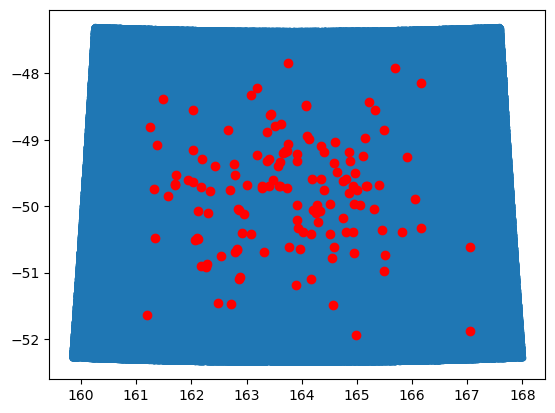

In [12]:
unwise_table = unwise_tables[0]

fig, ax = plt.subplots(1,1)

ax.scatter(
    unwise_table["RAJ2000"],
    unwise_table["DEJ2000"],
    marker="."
)

cata_tab = catas[24].table
ax.scatter(
    cata_tab["ra"],
    cata_tab["dec"],
    marker="o",
    color="red"
)


In [13]:
if False:
    results = []
    shifted_table = catas[24].table.copy()
    cata_sky = SkyCoord(shifted_table["ra"], shifted_table[4].table["dec"], unit=(u.deg, u.deg))
    
    decs = np.linspace(-5, 5, 100)
    ras = np.linspace(-5, 5, 100)
    results = {}
    
    before = time()
    
    for d_idx, dec in enumerate(decs):
        if d_idx % 5 == 0:
            print(d_idx)
        for r_idx, ra in enumerate(ras):
            
            shifted_sky = add_offset_to_coords_skyframeoffset(cata_sky, (ra, dec))
            
            matches = match_coordinates_sky(shifted_sky, unwise_sky, nthneighbor=1, storekdtree="beam24")
            results[(d_idx, r_idx)] = (dec, ra, np.sum(matches[1].value))
    
    after = time()        
    
    print(f"Took {after-before} seconds")
    
    accumulated_seps = np.zeros((100,100))
    
    minimum_seps = None
    minimum_key = None
    for k, v in results.items():
        accumulated_seps[k] = v[2]
    
        if minimum_key is None or minimum_seps[2] > v[2]:
            minimum_key = k
            minimum_seps = v
    
    print(f"{minimum_key=} {minimum_seps=}")
    
    fig, ax = plt.subplots(1,1)
    
    cim = ax.imshow(
        accumulated_seps, extent=(-5, 5, -5, 5), origin="lower"
    )
    
    ax.grid()
    ax.axvline(minimum_seps[1], ls="--", color="white")
    ax.axhline(minimum_seps[0], ls="--", color="white")
    
    ax.set(
        xlabel="Delta RA (arcsec)",
        ylabel="Delta Dec (arcsec)",
    )
    fig.colorbar(cim, label="Summed offsets (Degrees)")


In [14]:
# def add_offset_to_coords_skyframeoffset2(sky_coords, offset):
#     d_ra = -offset[0]*u.arcsec
#     d_dec = -offset[1]*u.arcsec
    
#     new_coords = sky_coords.spherical_offsets_by(
#         d_ra, d_dec
#     )
#     return new_coords



# shifted_table = catas[24].table.copy()
# cata_sky = SkyCoord(shifted_table["ra"], shifted_table["dec"], unit=(u.deg, u.deg))

# decs = np.linspace(-5, 5, 100)
# ras = np.linspace(-5, 5, 100)
# coords = []

# before = time()
# no_sources = len(cata_sky)
# no_delta = no_sources * len(decs)*len(ras)

# broadcast_d_ra = np.zeros(no_delta)
# broadcast_d_dec = np.zeros(no_delta)

# for d_idx, dec in enumerate(decs):
#     for r_idx, ra in enumerate(ras):
#         _i = len(coords)
#         _j = _i + 1
#         broadcast_d_ra[_i*no_sources:_j*no_sources] = ra
#         broadcast_d_dec[_i*no_sources:_j*no_sources] = dec
        
#         coords.append(cata_sky)

# print(f"{len(coords)=}")
# print("Concatenating sky coords")
# collected_coords = concatenate(coords)

# print("Forming shift positions")
# shifted_sky = add_offset_to_coords_skyframeoffset2(collected_coords, (broadcast_d_ra, broadcast_d_dec))

# print("Matching")
# matches = match_coordinates_sky(shifted_sky, unwise_sky, nthneighbor=1, storekdtree=True)

# accumulated_seps = np.zeros((100,100))

# results = {}
# minimum_key = None
# minimum_seps = None
# for d_idx, dec in enumerate(decs):
#     for r_idx, ra in enumerate(ras):
#         start_idx = (d_idx*len(ras) + r_idx)
#         end_idx = start_idx + 1
#         k = (d_idx, r_idx)
#         v = np.sum(matches[1][start_idx*no_sources:end_idx*no_sources].value)
#         seps = (dec, ra, v)
#         results[k] = seps
#         accumulated_seps[k] = v
        
#         if minimum_key is None or minimum_seps[2] > v:
#                     minimum_key = k
#                     minimum_seps = seps
            

# after = time()
# print(f"Took {after - before} seconds to complete")
# print(f"{minimum_key=} {minimum_seps=}")

# fig, ax = plt.subplots(1,1)

# cim = ax.imshow(
#     accumulated_seps, extent=(-5, 5, -5, 5), origin="lower"
# )

# ax.grid()
# ax.axvline(minimum_seps[1], ls="--", color="white")
# ax.axhline(minimum_seps[0], ls="--", color="white")

# ax.set(
#     xlabel="Delta RA (arcsec)",
#     ylabel="Delta Dec (arcsec)",
# )
# cbar = fig.colorbar(cim, label="Summed offsets (Degrees)")

In [15]:
def add_offset_to_coords_skyframeoffset2(sky_coords, offset):
    d_ra = -offset[0]*u.arcsec
    d_dec = -offset[1]*u.arcsec
    
    new_coords = sky_coords.spherical_offsets_by(
        d_ra, d_dec
    )
    return new_coords

def download_unwise(cata, radius_deg: float=5.):
    unwise = "II/363/unwise"
    print(f"Downloading {unwise} table for beam {cata.beam}")

    coord = cata.center
    vizier.Vizier.ROW_LIMIT = -1
    unwise_tables = vizier.Vizier(columns=["RAJ2000", "DEJ2000"], row_limit=-1).query_region(coord, catalog=unwise, width=radius_deg*u.deg, )

    assert len(unwise_tables) == 1
    
    return unwise_tables[0]

@dataclass
class OffsetGridSpace:
    dec_offsets: float
    ra_offsets: float
    beam: int
    seps: np.ndarray
    no_sources: int

@dataclass
class MinimumPoint:
    dec: float
    ra: float
    sep: int

def find_minimum_offset_space(offset_space):
    minimum_sep = None
    mininum_pos = None
    for (dec, ra, sep) in zip(offset_space.dec_offsets, offset_space.ra_offsets, offset_space.seps.flatten()):
        if minimum_sep is None or minimum_sep > sep:
            minimum_sep = sep
            minimum_pos = (dec, ra)

    return MinimumPoint(ra=minimum_pos[1], dec=minimum_pos[0], sep=minimum_sep)


def get_offset_space(cata, plot=True, remove_offset: bool=False, radius_deg: float=5.):
    unwise_table = download_unwise(cata, radius_deg=radius_deg)
    unwise_sky = SkyCoord(unwise_table["RAJ2000"], unwise_table["DEJ2000"], unit=(u.deg, u.deg))
    

    if remove_offset:
        offset = [-c for c in cata.offset]
        cata = add_offset_to_cata(cata, offset)
    shifted_table = cata.table.copy()
    cata_sky = SkyCoord(shifted_table["ra"], shifted_table["dec"], unit=(u.deg, u.deg))

    decs = np.linspace(-5, 5, 100)
    ras = np.linspace(-5, 5, 100)
    coords = []
    
    before = time()
    no_sources = len(cata_sky)
    no_delta = no_sources * len(decs)*len(ras)
    
    broadcast_d_ra = np.zeros(no_delta)
    broadcast_d_dec = np.zeros(no_delta)
    
    for d_idx, dec in enumerate(decs):
        for r_idx, ra in enumerate(ras):
            _i = len(coords)
            _j = _i + 1
            broadcast_d_ra[_i*no_sources:_j*no_sources] = ra
            broadcast_d_dec[_i*no_sources:_j*no_sources] = dec
            
            coords.append(cata_sky)
    
    print("Concatenating sky coords")
    collected_coords = concatenate(coords)
    
    print("Forming shift positions")
    shifted_sky = add_offset_to_coords_skyframeoffset2(collected_coords, (broadcast_d_ra, broadcast_d_dec))
    
    print("Matching")
    matches = match_coordinates_sky(shifted_sky, unwise_sky, nthneighbor=1, storekdtree=True)
    
    accumulated_seps = np.zeros((100,100))
    
    results = {}
    minimum_key = None
    minimum_seps = None
    pair_decra = []
    
    for d_idx, dec in enumerate(decs):
        for r_idx, ra in enumerate(ras):
            start_idx = (d_idx*len(ras) + r_idx)
            end_idx = start_idx + 1
            k = (d_idx, r_idx)
            v = np.sum(matches[1][start_idx*no_sources:end_idx*no_sources].value) / no_sources
    
            seps = (dec, ra, v)
            pair_decra.append((dec, ra))
            results[k] = seps
            accumulated_seps[k] = v

    after = time()
    print(f"Took {after - before} seconds to complete")

    array_decra = np.array(pair_decra)
    
    return OffsetGridSpace(
        dec_offsets=array_decra[:,0], ra_offsets=array_decra[:,1], beam=cata.beam, no_sources=no_sources, seps=accumulated_seps
    )
        
def plot_offset_grid_space(offset_grid_space):
    minimum_point =find_minimum_offset_space(offset_grid_space)

    min_dec = minimum_point.dec
    min_ra = minimum_point.ra
    
    fig, ax = plt.subplots(1,1)

            
    cim = ax.imshow(
        offset_grid_space.seps, extent=(-5, 5, -5, 5), origin="lower"
    )
    
    ax.grid()
    ax.axvline(min_dec, ls="--", color="white")
    ax.axhline(min_ra, ls="--", color="white")
    
    ax.set(
        xlabel="Delta RA (arcsec)",
        ylabel="Delta Dec (arcsec)",
        title=f"Beam {offset_grid_space.beam} ({min_ra:.4f} {min_dec:.4f}) arcsec {offset_grid_space.no_sources} beam srcs"
    )
    cbar = fig.colorbar(cim, label="Summed offsets (Degrees)")

    fig.tight_layout()



In [16]:
plt.close("all")
offset_results = [get_offset_space(cata) for cata in catas]
shifted_offset_results = [get_offset_space(cata, remove_offset=True) for cata in catas]


Concatenating sky coords
Forming shift positions
Matching
Took 6.831326246261597 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 6.515661716461182 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 7.544198989868164 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 7.410085201263428 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 6.724334001541138 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 6.791632175445557 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 6.545130968093872 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 7.428020000457764 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 7.868933916091919 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 8.551741123199463 seconds to

Matching
Took 5.849135875701904 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 4.590920925140381 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 3.447154998779297 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 5.533060073852539 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 5.196860074996948 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 5.706947088241577 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 3.8527472019195557 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 5.283769845962524 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 2.8403120040893555 seconds to complete
Concatenating sky coords
Forming shift positions
Matching
Took 3.8524069786071777 seconds to complete
Concatenating sky coords
Forming shi

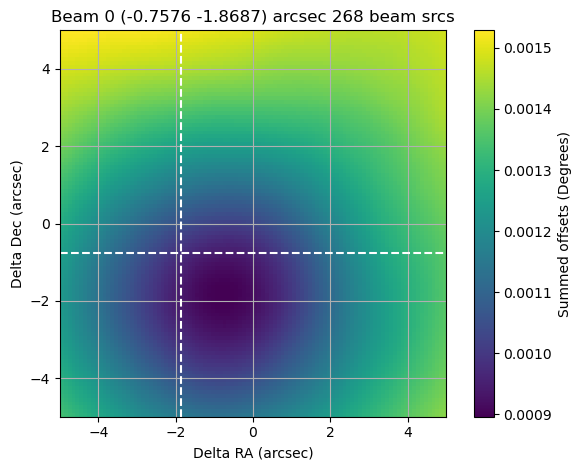

In [17]:
find_minimum_offset_space(offset_results[0])
plot_offset_grid_space(offset_results[0])

In [18]:
def plot_offset_grid_space(offset_grid_space, ax=None):
    minimum_point =find_minimum_offset_space(offset_grid_space)

    min_dec = minimum_point.dec
    min_ra = minimum_point.ra

    plot_cbar = False
    if ax is None:
        fig, ax = plt.subplots(1,1)
        plot_cbar = True
    
    cim = ax.imshow(
        offset_grid_space.seps, extent=(-5, 5, -5, 5), origin="lower"
    )
    
    ax.grid()
    ax.axhline(min_dec, ls="--", color="white")
    ax.axvline(min_ra, ls="--", color="white")
    
    if plot_cbar:
        cbar = fig.colorbar(cim, label="Summed offsets (Degrees)")

        ax.set(
                xlabel="Delta RA (arcsec)",
                ylabel="Delta Dec (arcsec)",
                title=f"Beam {offset_grid_space.beam} ({min_ra:.4f} {min_dec:.4f}) arcsec {offset_grid_space.no_sources} beam srcs"
            )
        
        fig.tight_layout()

def plot_offsets_in_field(offset_results, fig_title=None):
    fig, axes = plt.subplots(6,6, figsize=(10,10))
    
    for offset_result, ax in zip(offset_results, axes.flatten()):
        plot_offset_grid_space(offset_result, ax=ax)
    
    for ax in axes.flatten():
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.grid()
    
    if fig_title:
        fig.suptitle(fig_title)
    fig.tight_layout()


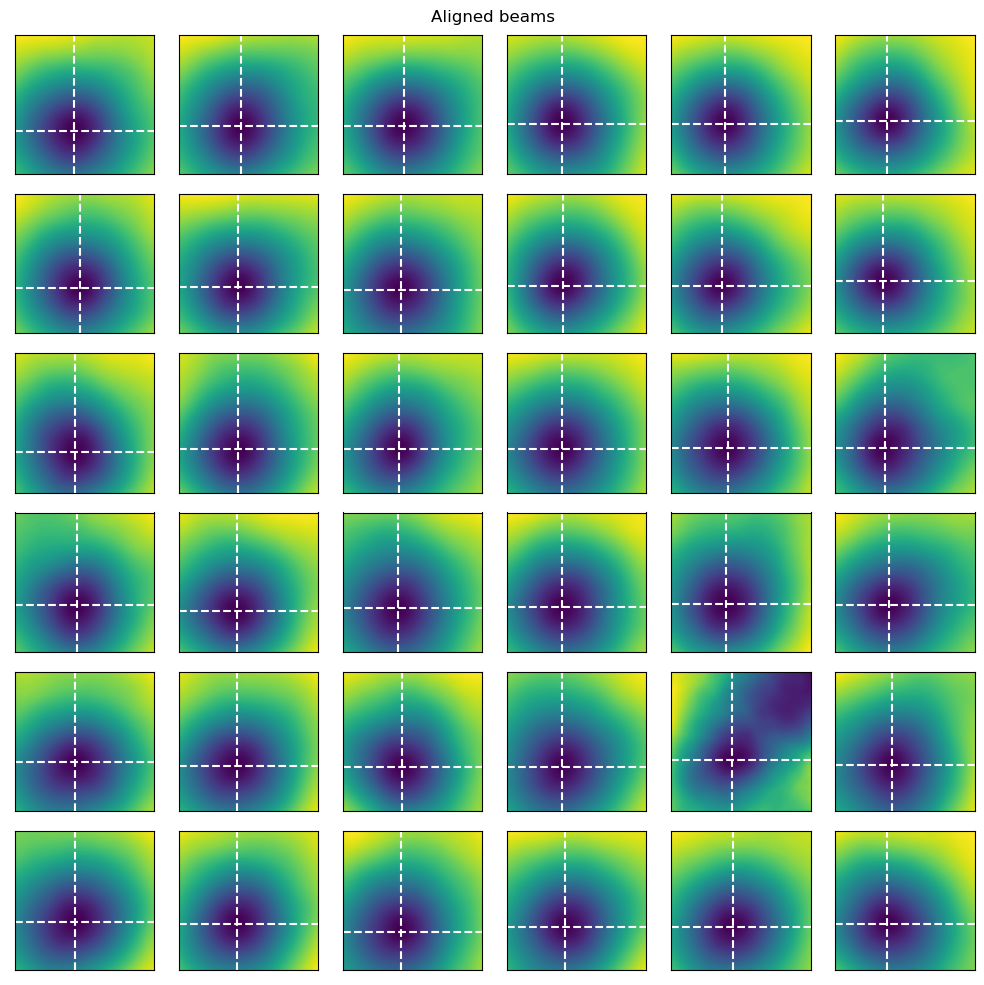

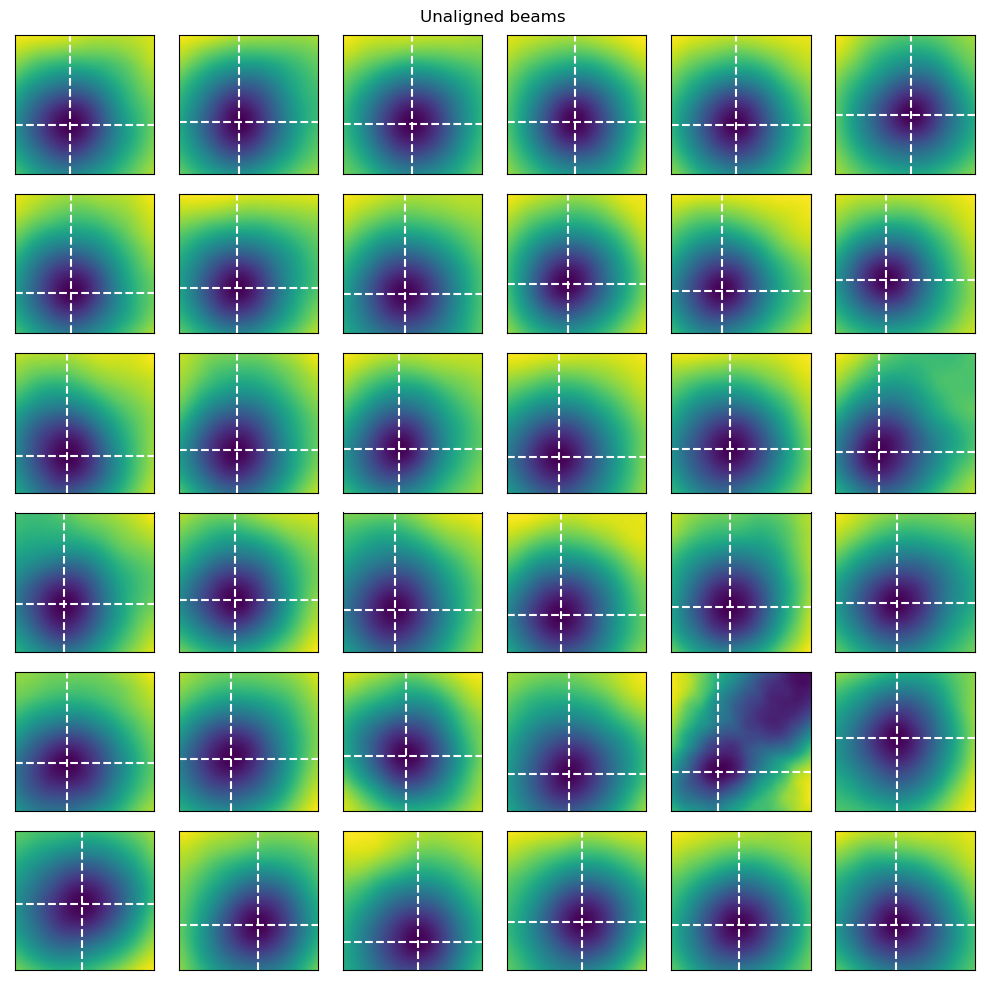

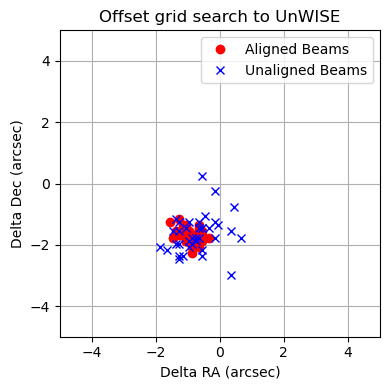

In [22]:
plot_offsets_in_field(offset_results, fig_title="Aligned beams")
plot_offsets_in_field(shifted_offset_results, fig_title="Unaligned beams")

fig, ax = plt.subplots(1,1, figsize=(4,4))

minimum_points = [find_minimum_offset_space(offset_result) for offset_result in offset_results]
minimum_points = np.array([(mp.ra, mp.dec) for mp in minimum_points])

shifted_minimum_points = [find_minimum_offset_space(offset_result) for offset_result in shifted_offset_results]
shifted_minimum_points = np.array([(mp.ra, mp.dec) for mp in shifted_minimum_points])

ax.plot(minimum_points[:,0], minimum_points[:,1], 'ro', label="Aligned Beams")
ax.plot(shifted_minimum_points[:,0], shifted_minimum_points[:,1], 'bx', label="Unaligned Beams")

ax.legend()

ax.set(
    xlim=[-5,5],
    ylim=[-5,5],
    xlabel="Delta RA (arcsec)",
    ylabel="Delta Dec (arcsec)",
    title="Offset grid search to UnWISE"
)
ax.grid()
fig.tight_layout()

In [20]:
# This is not the right way off doing the whole field. The stacking
# are on the **misaligned** beams!!

import copy
from astropy.table import vstack
all_cata = copy.deepcopy(catas[0])
all_cata.table = vstack([c.table for c in catas])

offset_space = get_offset_space(cata=all_cata, radius_deg=10)


Concatenating sky coords
Forming shift positions
Matching
Took 294.2224621772766 seconds to complete


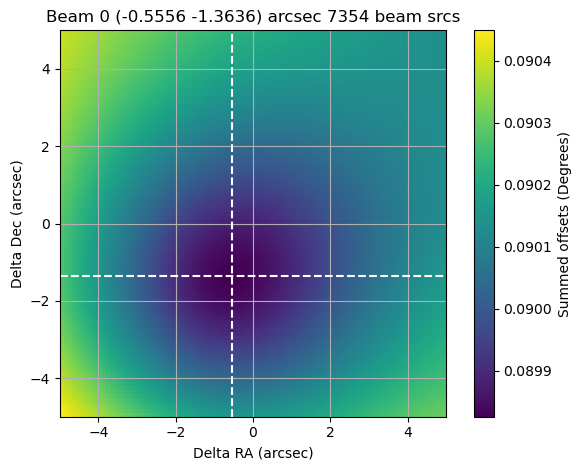

In [21]:
plot_offset_grid_space(offset_space)